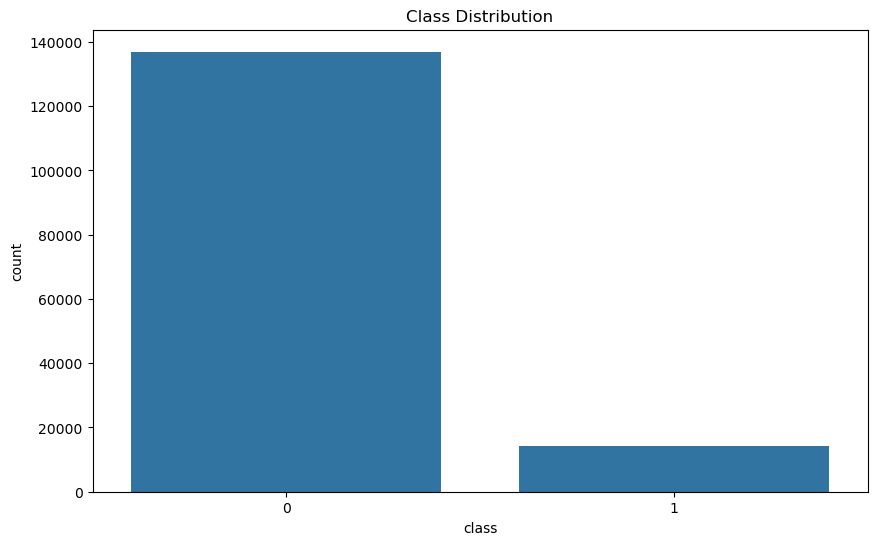

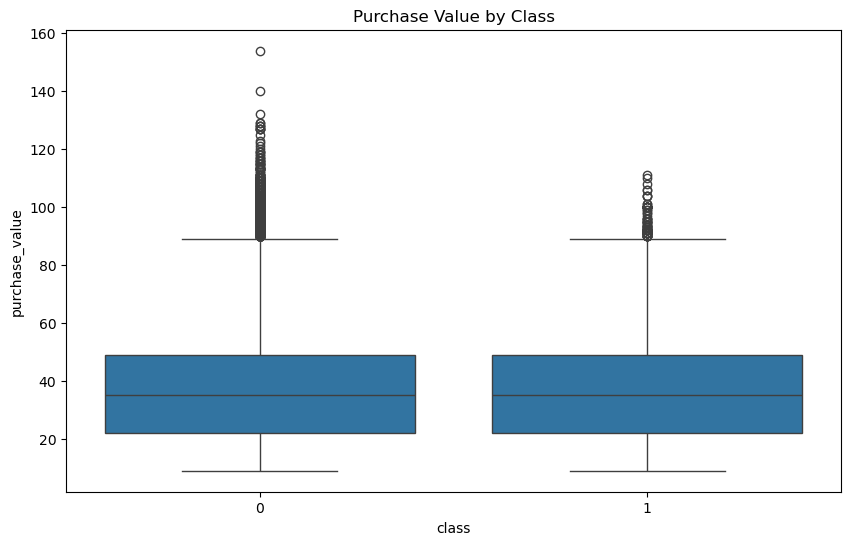

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
df = pd.read_csv('../data/processed/processed_Fraud_Data.csv')

# Univariate analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

# Bivariate analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=df)
plt.title('Purchase Value by Class')
plt.show()


In [3]:
fraud_data =pd.read_csv("../data/raw/Fraud_Data.csv")

In [4]:
ip_data= pd.read_csv("../data/raw/IpAddress_to_Country.csv")

In [5]:
credit_data=pd.read_csv("../data/raw/creditcard.csv")

In [9]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [11]:
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
# Compute summary statistics for purchase_value in Fraud_Data.csv
purchase_value_stats = fraud_data['purchase_value'].describe()

# Compute summary statistics for Amount in creditcard.csv
amount_stats = credit_data['Amount'].describe()

In [9]:
amount_stats



count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [7]:
purchase_value_stats

count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64

In [6]:
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [8]:
print("Data Types of fraud Data\n\n" ,fraud_data.dtypes)
print("Data Types of Ip Data\n\n" ,ip_data.dtypes)
print("Data Types of credit Data\n\n" ,credit_data.dtypes)

Data Types of fraud Data

 user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object
Data Types of Ip Data

 lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object
Data Types of credit Data

 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V

In [9]:
print("-----------------------Null value count fro fraud data\n\n",fraud_data.isnull().sum())

print("++++++++++++++++++++++++++++Null value count for ip data\n\n",ip_data.isnull().sum())

print("_____________________Null value count for credit data\n\n",credit_data.isnull().sum())

-----------------------Null value count fro fraud data

 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
++++++++++++++++++++++++++++Null value count for ip data

 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
_____________________Null value count for credit data

 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [13]:
merged_data = pd.read_csv("../data/processed/merged_data.csv", low_memory=False)

In [16]:
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2809315199,0,Canada


In [17]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)
credit_data.drop_duplicates(inplace=True)

# Correct data types if necessary
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])


In [18]:
fraud_data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [17]:
print(fraud_data['purchase_value'].dtype)


int64


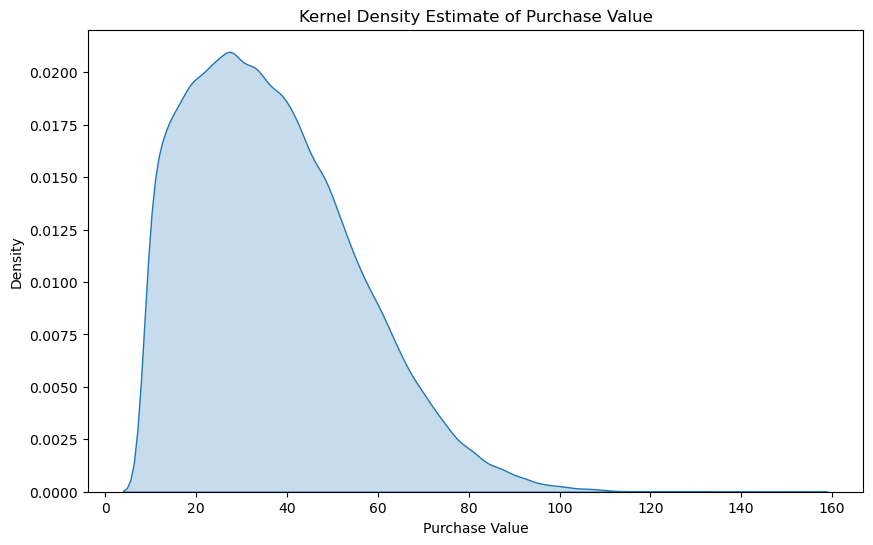

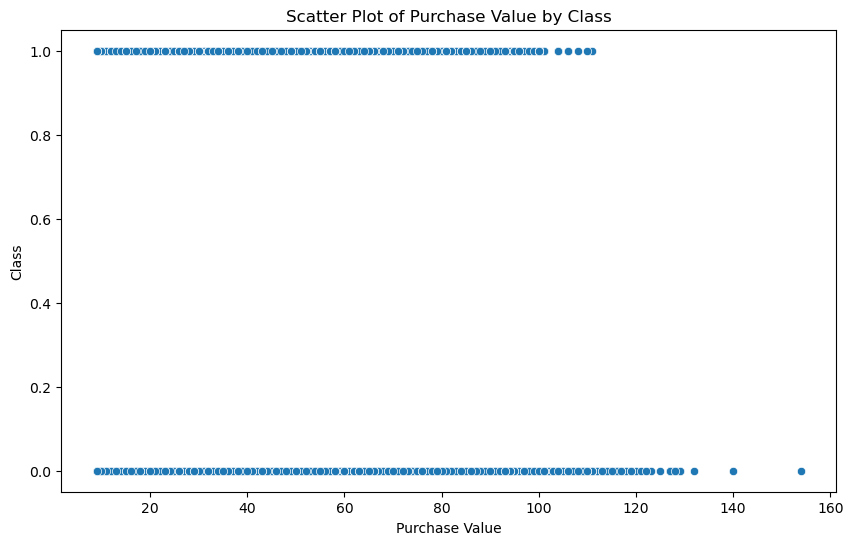

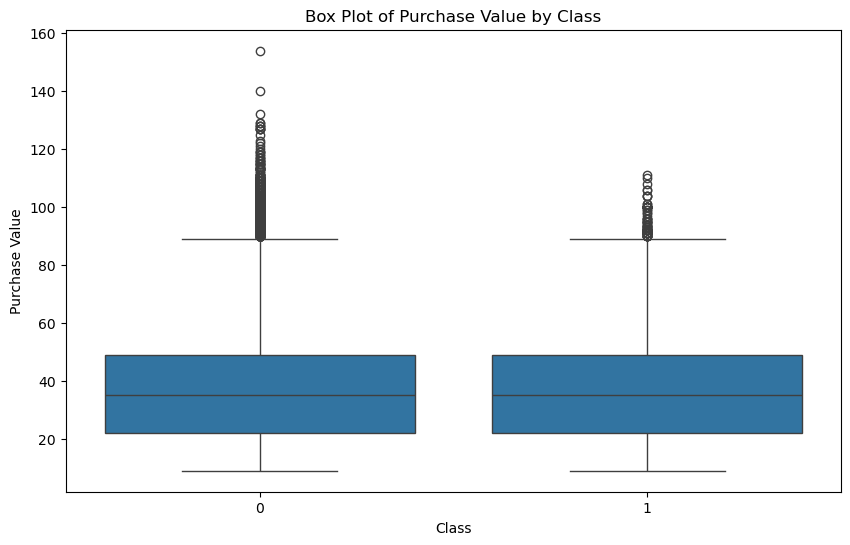

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Univariate analysis - KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=fraud_data, x='purchase_value', fill=True)
plt.title('Kernel Density Estimate of Purchase Value')
plt.xlabel('Purchase Value')
plt.ylabel('Density')
plt.show()

# Bivariate analysis - Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=fraud_data, x='purchase_value', y='class')
plt.title('Scatter Plot of Purchase Value by Class')
plt.xlabel('Purchase Value')
plt.ylabel('Class')
plt.show()

# Bivariate analysis - Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_data, x='class', y='purchase_value')
plt.title('Box Plot of Purchase Value by Class')
plt.xlabel('Class')
plt.ylabel('Purchase Value')
plt.show()

In [8]:
processed= pd.read_csv("../data/processed/processed_Data.csv")

In [9]:
processed.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058.0,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160204,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,732758368,...,False,False,False,False,False,False,False,False,False,False
1,333320.0,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142592,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,350311387,...,True,False,False,False,False,False,False,False,False,False
2,1359.0,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197169,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2621473820,...,True,False,False,False,False,False,False,False,False,False
3,150084.0,2015-04-28 21:13:25,2015-05-04 13:54:50,0.385567,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3840542443,...,False,False,False,False,False,False,False,False,False,False
4,221365.0,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112681,NAUITBZFJKHWW,Ads,Safari,M,45.0,415583117,...,True,False,False,False,False,False,False,False,False,False


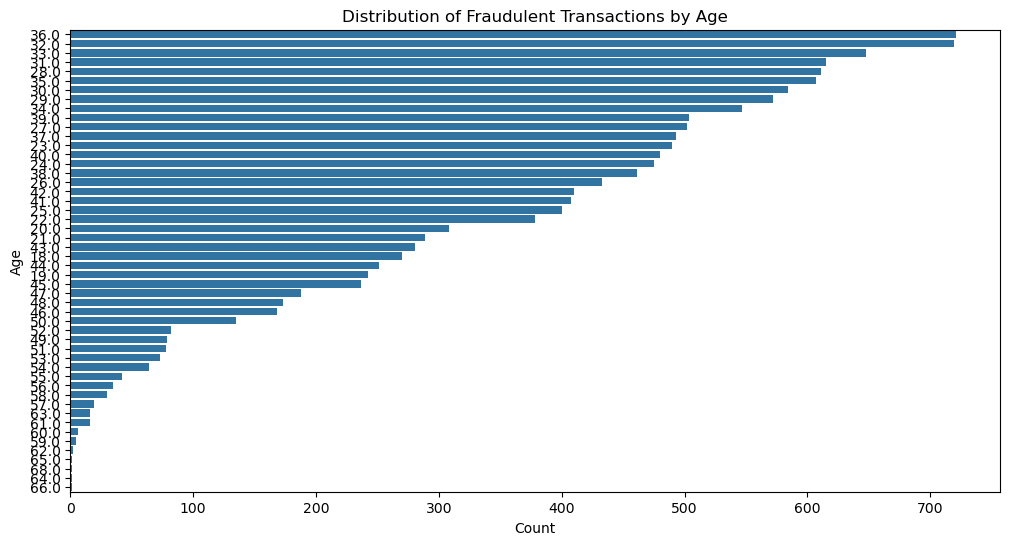

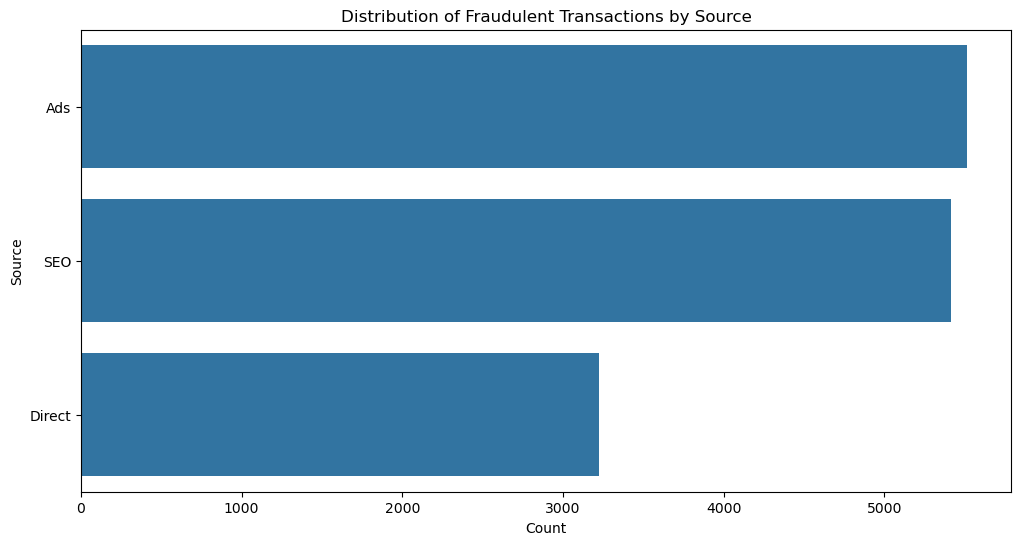

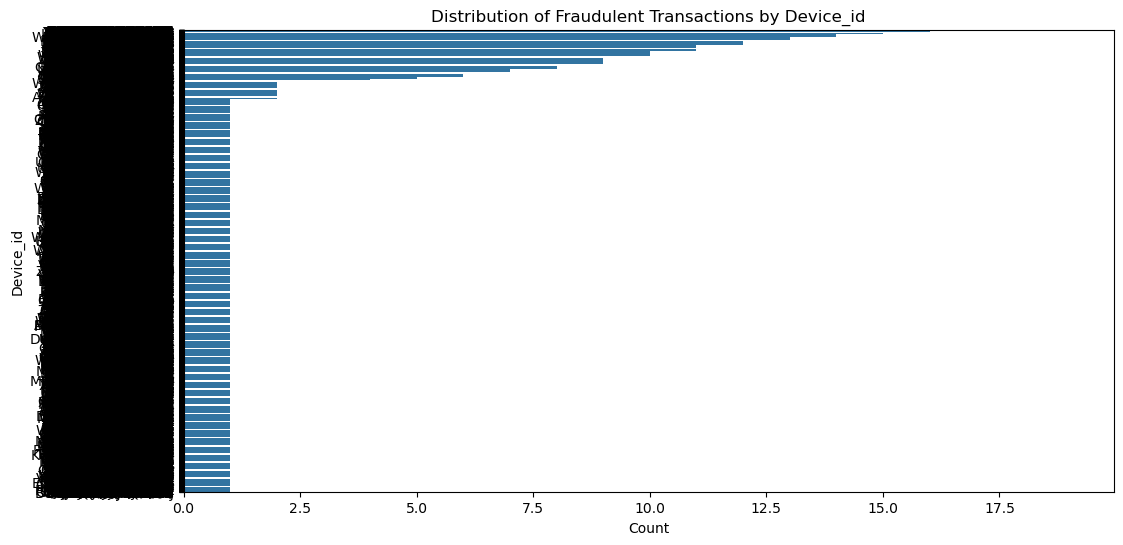

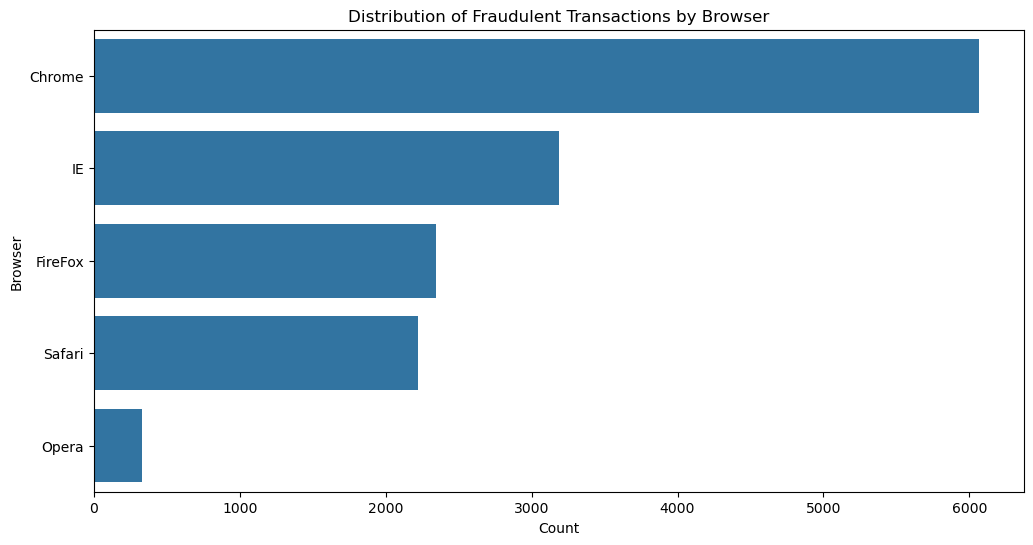

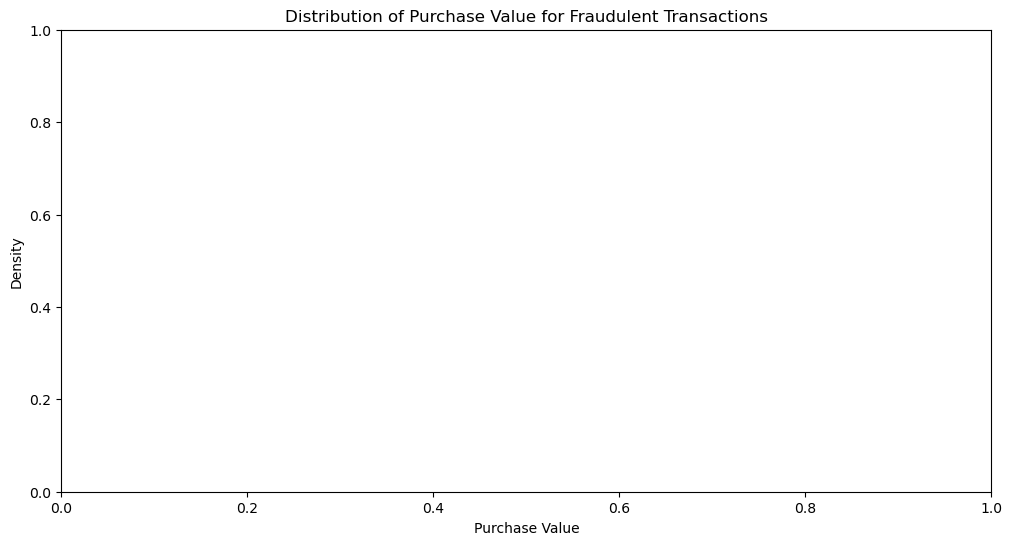

count    14151.000000
mean         0.003145
std          1.004091
min         -1.524632
25%         -0.815129
50%         -0.105627
75%          0.658452
max          4.042233
Name: purchase_value, dtype: float64


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load processed data
processed_data = pd.read_csv('../data/processed/processed_Data.csv')

# Filter fraudulent transactions
fraudulent_data = processed_data[processed_data['class'] == 1]

# Analyze the distribution of fraudulent transactions by country
def analyze_fraud_by_feature(data, feature):
    plt.figure(figsize=(12, 6))
    sns.countplot(y=feature, data=data, order=data[feature].value_counts().index)
    plt.title(f'Distribution of Fraudulent Transactions by {feature.capitalize()}')
    plt.xlabel('Count')
    plt.ylabel(feature.capitalize())
    plt.show()

# Plot analysis for each feature
analyze_fraud_by_feature(fraudulent_data, 'age')
analyze_fraud_by_feature(fraudulent_data, 'source')
analyze_fraud_by_feature(fraudulent_data, 'device_id')
analyze_fraud_by_feature(fraudulent_data, 'browser')

# Analyze purchase_value for fraudulent transactions
plt.figure(figsize=(12, 6))
# plt.pie(data=fraudulent_data, x='purchase_value')
plt.title('Distribution of Purchase Value for Fraudulent Transactions')
plt.xlabel('Purchase Value')
plt.ylabel('Density')
plt.show()

# Display summary statistics for purchase_value
print(fraudulent_data['purchase_value'].describe())


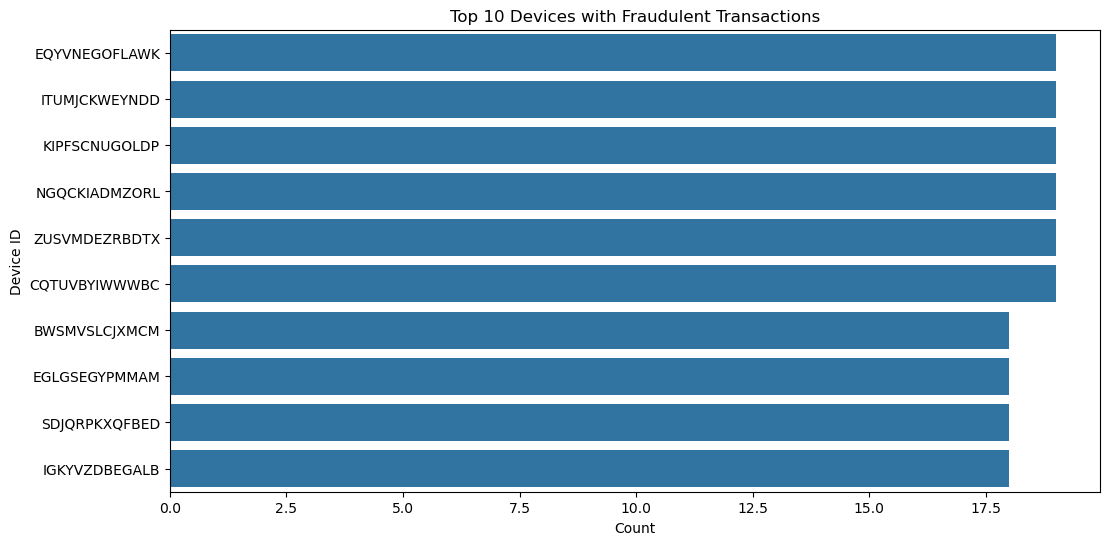

/tmp/ipykernel_35074/3622935610.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=fraudulent_data['purchase_value'], shade=True)


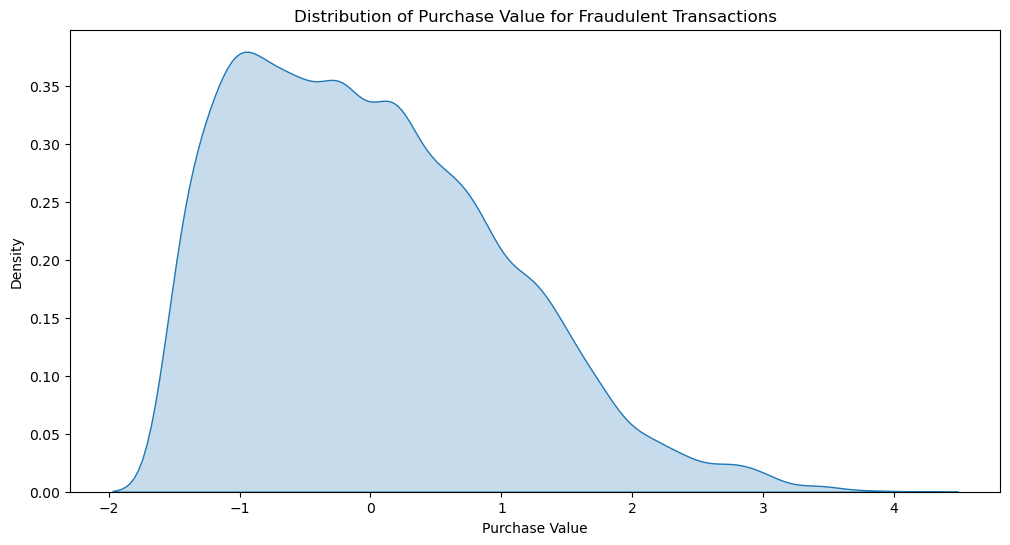

count    14151.000000
mean         0.003145
std          1.004091
min         -1.524632
25%         -0.815129
50%         -0.105627
75%          0.658452
max          4.042233
Name: purchase_value, dtype: float64


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load processed data (adjust path as necessary)
processed_data = pd.read_csv('../data/processed/processed_Data.csv')

# Filter fraudulent transactions
fraudulent_data = processed_data[processed_data['class'] == 1]

# Analyze the distribution of fraudulent transactions by device_id
def analyze_fraud_by_feature(data, feature):
    plt.figure(figsize=(12, 6))
    sns.countplot(y=feature, data=data, order=data[feature].value_counts().index[:10])
    plt.title(f'Top 10 Devices with Fraudulent Transactions')
    plt.xlabel('Count')
    plt.ylabel('Device ID')
    plt.show()

# Plot analysis for top 10 devices associated with fraudulent transactions
analyze_fraud_by_feature(fraudulent_data, 'device_id')

# Analyze purchase_value for fraudulent transactions using KDE plot
plt.figure(figsize=(12, 6))
sns.kdeplot(data=fraudulent_data['purchase_value'], shade=True)
plt.title('Distribution of Purchase Value for Fraudulent Transactions')
plt.xlabel('Purchase Value')
plt.ylabel('Density')
plt.show()

# Display summary statistics for purchase_value
print(fraudulent_data['purchase_value'].describe())
